In [2]:
import os
import sys
import copy
sys.path.append("../")
import numpy as np
import pandas as pd
import re
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from pathlib import Path
from datetime import datetime
import datetime
import yaml
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold 
from modeling.build import build_models
from utils.utils import seed_all
from torch import nn
import torch
seed_all(42)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
# setting up default plotting parameters
%matplotlib inline

plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22,})

sns.set_palette('viridis')
sns.set_style('white')
sns.set_context('talk', font_scale=0.8)

# from utils.eda import plot_corr_heatmap, desc_correlation

pd.options.display.max_rows = None
pd.options.display.max_columns = None

## *Load Data & Configs*

In [3]:
# Load data
DATA_PATH = Path("../data/")
df = pd.read_csv(DATA_PATH / "train_v1.csv", parse_dates=['date'], index_col=[0])
print(f"Shape: {df.shape}")
df.head()

Shape: (43066, 71)


,date,oven_id,layer_id,lamp_id,label,anomaly_accumulation_hour,power,Slot1_water_volume,Slot2_water_volume,Slot3_water_volume,Slot4_water_volume,Slot5_water_volume,Slot6_water_volume,Slot7_water_volume,Slot8_water_volume,Slot9_water_volume,Slot10_water_volume,Slot11_water_volume,Slot12_water_volume,Slot13_water_volume,Slot14_water_volume,Slot15_water_volume,Slot16_water_volume,Slot17_water_volume,Slot18_water_volume,Slot19_water_volume,Slot20_water_volume,Slot1-10_in_temperature,Slot1-10_out_temperature,Slot11-20_in_temperature,Slot11-20_out_temperature,S01_A_temperature,S01_B_temperature,S02_A_temperature,S02_B_temperature,S03_A_temperature,S03_B_temperature,S04_A_temperature,S04_B_temperature,S05_A_temperature,S05_B_temperature,S06_A_temperature,S06_B_temperature,S07_A_temperature,S07_B_temperature,S08_A_temperature,S08_B_temperature,S09_A_temperature,S09_B_temperature,S10_A_temperature,S10_B_temperature,S11_A_temperature,S11_B_temperature,S12_A_temperature,S12_B_temperature,S13_A_temperature,S13_B_temperature,S14_A_temperature,S14_B_temperature,S15_A_temperature,S15_B_temperature,S16_A_temperature,S16_B_temperature,S17_A_temperature,S17_B_temperature,S18_A_temperature,S18_B_temperature,S19_A_temperature,S19_B_temperature,S20_A_temperature,S20_B_temperature
0,2021-12-27,1B0,5,1,0,5116.0,63.5,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,9.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,20.3,24.8,20.0,24.6,23.3,25.2,24.2,22.4,23.5,23.1,24.8,25.7,25.1,24.5,24.8,23.8,25.1,25.1,25.0,24.6,27.9,26.9,26.1,25.9,29.6,25.9,26.9,25.9,27.7,27.0,27.7,25.8,26.2,27.0,26.9,26.6,30.9,26.8,25.6,27.2,26.9,27.2,NaN,NaN
1,2021-12-27,1B0,5,2,0,5116.0,63.5,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,9.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,20.3,24.8,20.0,24.6,23.3,25.2,24.2,22.4,23.5,23.1,24.8,25.7,25.1,24.5,24.8,23.8,25.1,25.1,25.0,24.6,27.9,26.9,26.1,25.9,29.6,25.9,26.9,25.9,27.7,27.0,27.7,25.8,26.2,27.0,26.9,26.6,30.9,26.8,25.6,27.2,26.9,27.2,NaN,NaN
2,2021-12-27,1B0,5,3,0,5116.0,59.5,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,9.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,20.3,24.8,20.0,24.6,23.3,25.2,24.2,22.4,23.5,23.1,24.8,25.7,25.1,24.5,24.8,23.8,25.1,25.1,25.0,24.6,27.9,26.9,26.1,25.9,29.6,25.9,26.9,25.9,27.7,27.0,27.7,25.8,26.2,27.0,26.9,26.6,30.9,26.8,25.6,27.2,26.9,27.2,NaN,NaN
3,2021-12-27,1B0,5,4,0,5116.0,59.5,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,9.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,20.3,24.8,20.0,24.6,23.3,25.2,24.2,22.4,23.5,23.1,24.8,25.7,25.1,24.5,24.8,23.8,25.1,25.1,25.0,24.6,27.9,26.9,26.1,25.9,29.6,25.9,26.9,25.9,27.7,27.0,27.7,25.8,26.2,27.0,26.9,26.6,30.9,26.8,25.6,27.2,26.9,27.2,NaN,NaN
4,2021-12-27,1B0,5,5,0,5116.0,59.5,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,9.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,20.3,24.8,20.0,24.6,23.3,25.2,24.2,22.4,23.5,23.1,24.8,25.7,25.1,24.5,24.8,23.8,25.1,25.1,25.0,24.6,27.9,26.9,26.1,25.9,29.6,25.9,26.9,25.9,27.7,27.0,27.7,25.8,26.2,27.0,26.9,26.6,30.9,26.8,25.6,27.2,26.9,27.2,NaN,NaN


In [11]:
# Load config
cfg_path = "../config/model/lgbmclf_template.yaml"
with open(cfg_path, "r") as f:
    model_cfg = yaml.full_load(f)
model_cfg["model_params"]

{'task': 'train',
 'objective': 'binary',
 'boosting': 'gbdt',
 'learning_rate': 0.01,
 'num_leaves': 50,
 'num_threads': -1,
 'device': 'gpu',
 'max_depth': 6,
 'min_data_in_leaf': 20,
 'min_sum_hessian_in_leaf': 1,
 'bagging_fraction': 0.8,
 'bagging_freq': 5,
 'feature_fraction': 0.8,
 'lambda_l1': 2,
 'lambda_l2': 7,
 'verbose': 1,
 'n_estimators': 2500,
 'verbose_eval': 250,
 'early_stopping_round': 500,
 'scale_pos_weight': 0.05,
 'random_state': 42}

In [5]:
# Get all feature columns
feat_cols = df.columns.to_list()
len(feat_cols)
feat_cols.remove("label")
feat_cols.remove("date")
feat_cols.remove("S20_A_temperature")
feat_cols.remove("S20_B_temperature")
# Get categorical feature columns
cat_cols = ["oven_id"]

len(feat_cols)

67

In [6]:
# Encode categorical feature
idx_oid = pd.DataFrame([[i, oid] for i, oid in enumerate(df.oven_id.unique())])
idx2oid = idx_oid.set_index(0).to_dict()[1]
oid2idx = idx_oid.set_index(1).to_dict()[0]

df["oven_id"] = df["oven_id"].map(oid2idx)

## *Classifier*

In [7]:

def _predict(model, x: pd.DataFrame) -> np.ndarray:
        """Do inference with the well-trained estimator.

        Parameters:
            model: well-trained estimator used to do inference
            x: data to predict on

        Return:
            y_pred: predicting results
        """
        y_pred = model.predict(x)

        return y_pred

def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

def final_eval_fn(df, oof):
    df["pred"] = oof
    rst = df.groupby(["date", "oven_id", "layer_id"]).agg({"label": "sum", "pred": "sum"})
    score = rmse(rst["label"], rst["pred"])
    return score
    

In [8]:
def train_eval(df):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_iter = kf.split(X=df, y=df["label"])

    models = build_models("lgbmclf", model_cfg["model_params"], kf.get_n_splits())

    # cv
    oof = np.zeros(len(df))
    oof_scores = []
    # eval_fn = logloss # TODO: define log loss
    # logs= []

    for ifold, (tr_idx, val_idx) in enumerate(cv_iter):
        tr_set, ts_set = df.iloc[tr_idx], df.iloc[val_idx]
        X_tr, y_tr = tr_set[feat_cols], tr_set["label"]
        X_val, y_val = ts_set[feat_cols], ts_set["label"]

        # Setup fit parameters
        fit_params_ifold = copy.copy(model_cfg["fit_params"])
        fit_params_ifold["eval_set"] = [(X_tr, y_tr), (X_val, y_val)]
        fit_params_ifold["categorical_feature"] = ["oven_id"]

        # Train the model
        models[ifold].fit(X_tr, y_tr, **fit_params_ifold)
        oof[val_idx] = _predict(models[ifold], X_val)
        
        # evaluated[val_idx] = True
        # tr_score = eval_fn(df.iloc[tr_idx], _predict(models[ifold], X_tr))
        # oof_score = eval_fn(df.iloc[val_idx], oof[val_idx])
        # exp_fold.log({"train": {"rmse": tr_score}, "oof": {"rmse": oof_score}})
        
        # log_str = f"(RMSE) |  Train: {tr_score} | oof: {oof_score}"
        # print(log_str)
        # logs.append(log_str)
        # oof_scores.append(oof_score)
        
        # Record feature importance
        # pass
        # break

    rst = {}
    # print(logs)
    rst["oof_score"] = final_eval_fn(df, oof)
    # print(f"(RMSE) | oof: {oof_score}")

    # f1 score
    rst["f1_score"] = f1_score(df.label, oof)
    # confusion matrix
    rst["conf_matix"] = pd.DataFrame(confusion_matrix(df.label, oof))
    rst["recall_score"] = recall_score(df.label, oof)

    return rst, oof

In [164]:
rst = train_eval(df)
rst

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7,

{'oof_score': 2.337646088510294,
 'f1_score': 0.0,
 'conf_matix':        0  1
 0  42285  0
 1    781  0,
 'recall_score': 0.0}

## *Resampling Techniques*

In [ ]:
from sklearn.utils import resample

def train_eval(df, is_resample=""):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_iter = kf.split(X=df, y=df["label"])

    models = build_models("lgbmclf", model_cfg["model_params"], kf.get_n_splits())

    # cv
    oof = np.zeros(len(df))
    oof_scores = []
    # eval_fn = logloss # TODO: define log loss
    # logs= []

    for ifold, (tr_idx, val_idx) in enumerate(cv_iter):
        tr_set, ts_set = df.iloc[tr_idx], df.iloc[val_idx]

        if is_resample != "":
            normal_sample = tr_set[tr_set.label == 0]
            anomaly_sample = tr_set[tr_set.label == 1]
            if is_resample == "upsample":
                # Upsample minority
                anomaly_upsampled = resample(anomaly_sample,
                                            replace=True, # sample with replacement
                                            n_samples=len(normal_sample), # match number in majority class
                                            random_state=42) # reproducible results
                # combine majority and upsampled minority
                tr_set = pd.concat([normal_sample, anomaly_upsampled])
            elif is_resample == "downsample":
                # Downsample majority
                normal_downsampled = resample(normal_sample,
                                                replace = False, # sample without replacement
                                                n_samples = len(anomaly_sample), # match minority n
                                                random_state = 42) # reproducible results
                # combine minority and downsampled majority
                tr_set = pd.concat([normal_downsampled, anomaly_sample])


        X_tr, y_tr = tr_set[feat_cols], tr_set["label"]
        X_val, y_val = ts_set[feat_cols], ts_set["label"]

        # Setup fit parameters
        fit_params_ifold = copy.copy(model_cfg["fit_params"])
        fit_params_ifold["eval_set"] = [(X_tr, y_tr), (X_val, y_val)]
        fit_params_ifold["categorical_feature"] = ["oven_id"]

        # Train
        models[ifold].fit(X_tr, y_tr, **fit_params_ifold)
        oof[val_idx] = _predict(models[ifold], X_val)
        
        # evaluated[val_idx] = True
        # tr_score = eval_fn(df.iloc[tr_idx], _predict(models[ifold], X_tr))
        # oof_score = eval_fn(df.iloc[val_idx], oof[val_idx])
        # exp_fold.log({"train": {"rmse": tr_score}, "oof": {"rmse": oof_score}})
        
        # log_str = f"(RMSE) |  Train: {tr_score} | oof: {oof_score}"
        # print(log_str)
        # logs.append(log_str)
        # oof_scores.append(oof_score)
        
        # Record feature importance
        # pass
        # break

    rst = {}
    # print(logs)
    rst["oof_score"] = final_eval_fn(df, oof)
    # print(f"(RMSE) | oof: {oof_score}")

    # f1 score
    rst["f1_score"] = f1_score(df.label, oof)
    # confusion matrix
    rst["conf_matix"] = pd.DataFrame(confusion_matrix(df.label, oof))
    rst["recall_score"] = recall_score(df.label, oof)

    return rst, oof

In [183]:
rst, oof = train_eval(df, is_resample="upsample")
print(rst)
final_eval_fn(df, oof) 

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7,

20.197677481269814

In [184]:
rst, oof = train_eval(df, is_resample="downsample")
print(rst)
final_eval_fn(df, oof) 

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7,

60.630048926758995

In [12]:
rst, oof = train_eval(df, is_resample="")
print(rst)

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8,

In [160]:
# upsampled.duplicated().sum()

41504

## *Imbalance Data*


In [138]:
print(df.label.value_counts())

0    42285
1      781
Name: label, dtype: int64


/home/yuchen/anaconda3/envs/rec/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


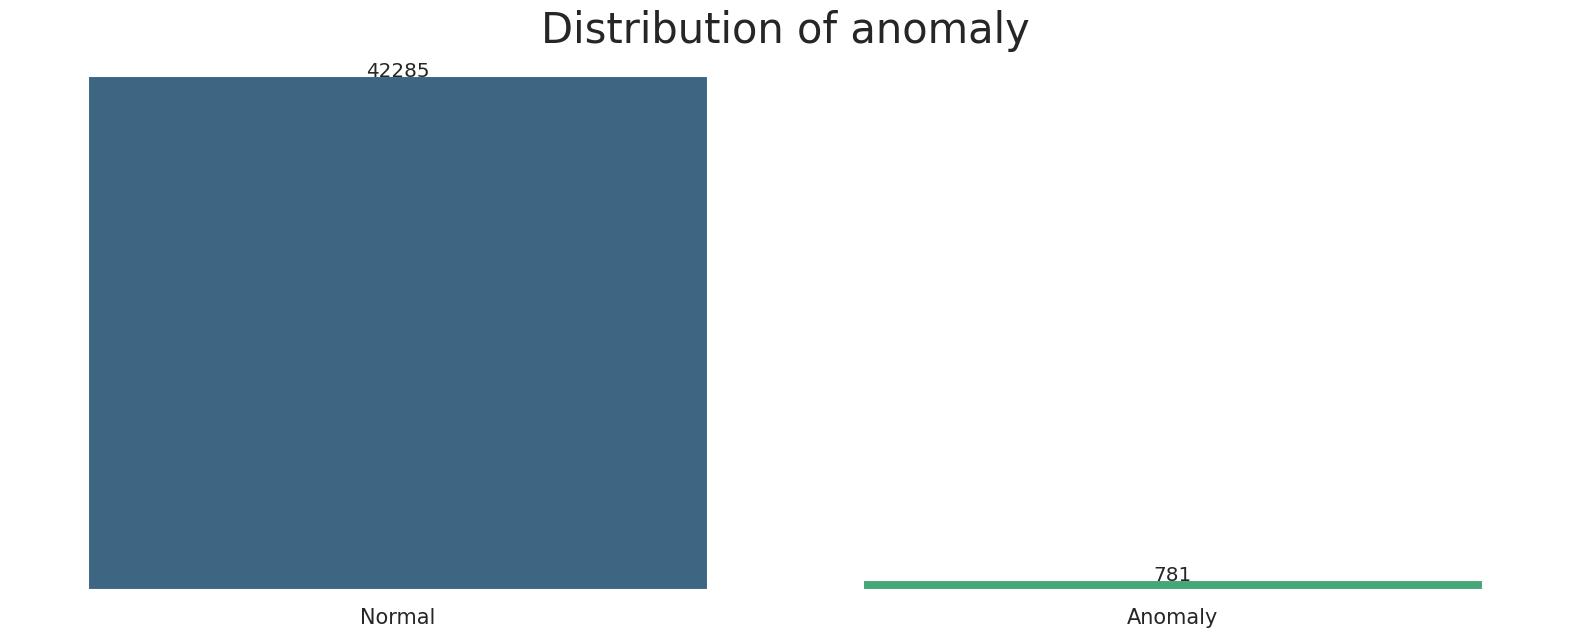

In [139]:
# using seaborns countplot to show distribution of questions in dataset
fig, ax = plt.subplots()
g = sns.countplot(df.label, palette='viridis')
g.set_xticklabels(['Normal', 'Anomaly'])
g.set_yticklabels([])

# function to show values on bars
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of anomaly', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.show()

In [143]:
print(f"{(len(df.loc[df.label==1])) / (len(df.loc[df.label == 0])) * 100}%")

1.8469906586259903%
